In [53]:
import skimage
import os
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import requests

%matplotlib inline

In [42]:
j = os.listdir('../../data/posters/')

'26302_poster.jpg'

In [5]:
images = ['../../data/posters/10547_poster.jpg', '../../data/posters/10312_poster.jpg']

In [72]:
with Image.open(BytesIO(requests.get('https://image.tmdb.org/t/p/w600_and_h900_bestv2/e64sOI48hQXyru7naBFyssKFxVd.jpg').content)) as im:
    im = im.resize((512, 512), resample=Image.LANCZOS)
    im.show()

In [49]:
data.resize((512, 512)).show()

In [36]:
rescaled_data = skimage.transform.resize(data, output_shape=(512, 512, 3), anti_aliasing=True)

In [37]:
data.shape

(900, 600, 3)

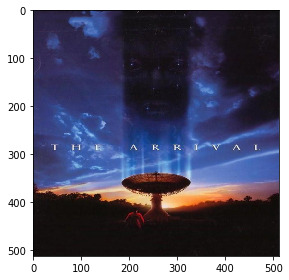

In [38]:
skimage.io.imshow(rescaled_data)

In [67]:
abc = None

In [68]:
if abc:
    print('hello')